- Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ.
- Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения.
- Попробуйте реализовать нейронную сеть архитектуры LSTM на numpy.
- Предложите свои варианты решения проблемы исчезающего градиента в RNN.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers import SimpleRNN, LSTM, GRU

In [3]:
tf.random.set_seed(1)

In [5]:
airline_passengers_data = pd.read_csv('airline-passengers.csv')

In [6]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
airline_passengers_data['Month'].value_counts()

Month
1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: count, Length: 144, dtype: int64

In [9]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [10]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [11]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

In [12]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


In [13]:
train_size = 100
features = ['Passengers', 'year', 'mon']
bias = 5
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]
train_data.shape, val_data.shape

((100, 3), (39, 3))

In [14]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [15]:
scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])
train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


In [16]:
x_len = 3
future = 1
learning_rate = 0.001
batch_size = 8
epochs = 10

In [17]:
start = x_len + future
end = start + train_size
print(start, end)
X_train = train_data[features].values
y_train = data.iloc[start:end][target].values
x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)
X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

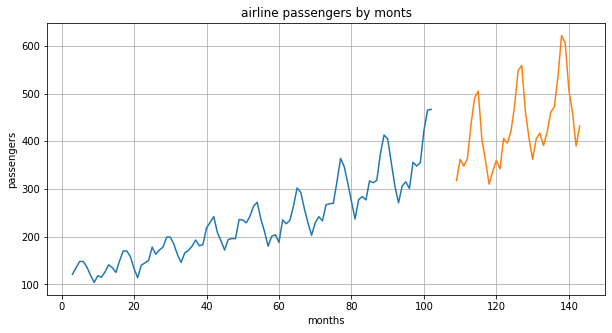

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [20]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

2023-09-28 12:35:38.061584: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [22]:
results = pd.DataFrame()
model = []
train_m = []
test_m = []

In [23]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)
model_1 = Sequential()
model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))
model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11687 (45.65 KB)
Trainable params: 11687 (

In [24]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 2s 33ms/step - loss: 57055.9727 - mae: 226.1374 - val_loss: 195556.1250 - val_mae: 434.9158
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 56556.1367 - mae: 225.1287 - val_loss: 193622.3906 - val_mae: 432.7460
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 56350.9336 - mae: 224.9650 - val_loss: 191910.9531 - val_mae: 430.8341
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 56017.6836 - mae: 224.5569 - val_loss: 189287.5469 - val_mae: 427.9017
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 55268.1289 - mae: 223.4905 - val_loss: 183851.7344 - val_mae: 421.7460
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 53414.7305 - mae: 220.5892 - val_loss: 171853.0312 - val_mae: 407.7361
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 48876.8281 - mae: 212.5775 - val_loss: 146547.9375 - val_mae: 376.197

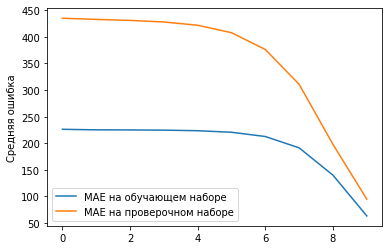

In [25]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [27]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 3345.6597 - mae: 49.4227 - val_loss: 14961.7070 - val_mae: 101.5272
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 1416.5428 - mae: 29.7071 - val_loss: 17008.0781 - val_mae: 109.2030
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 1125.0171 - mae: 26.4740 - val_loss: 12194.6094 - val_mae: 87.4218
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 1222.2902 - mae: 27.8984 - val_loss: 11851.5312 - val_mae: 86.3204
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 1111.8342 - mae: 26.3785 - val_loss: 12485.1797 - val_mae: 90.0671
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 1050.6171 - mae: 25.4975 - val_loss: 11910.1094 - val_mae: 87.4299
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 1016.2466 - mae: 24.9770 - val_loss: 11518.1982 - val_mae: 85.6198
Epoch 8/10
13/13 [=======

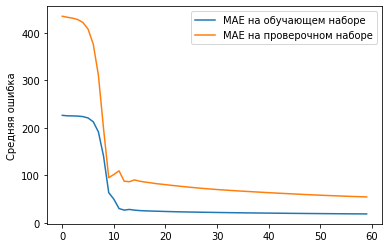

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 548.8100 - mae: 18.4096 - val_loss: 5327.2246 - val_mae: 53.9477
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 545.6943 - mae: 18.3563 - val_loss: 5279.0547 - val_mae: 53.6188
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 542.6841 - mae: 18.3073 - val_loss: 5232.7925 - val_mae: 53.2958
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 539.7666 - mae: 18.2607 - val_loss: 5188.3125 - val_mae: 52.9782
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 536.9290 - mae: 18.2145 - val_loss: 5145.4824 - val_mae: 52.6656
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 534.1592 - mae: 18.1734 - val_loss: 5104.1719 - val_mae: 52.3577
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 531.4448 - mae: 18.1317 - val_loss: 5064.2520 - val_mae: 52.0540
Epoch 8/10
13/13 [=======================

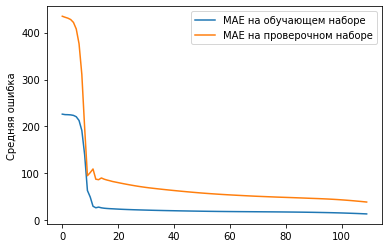

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 266.4352 - mae: 13.0929 - val_loss: 2668.2788 - val_mae: 38.1432
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 254.4955 - mae: 12.8238 - val_loss: 2569.2673 - val_mae: 37.5588
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 242.8177 - mae: 12.5454 - val_loss: 2471.1074 - val_mae: 36.9439
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 231.5251 - mae: 12.2688 - val_loss: 2374.6245 - val_mae: 36.3038
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 220.7359 - mae: 12.0185 - val_loss: 2280.6365 - val_mae: 35.6446
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 210.5561 - mae: 11.7747 - val_loss: 2189.9392 - val_mae: 34.9729
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 201.0692 - mae: 11.5272 - val_loss: 2103.2119 - val_mae: 34.3138
Epoch 8/10
13/13 [=======================

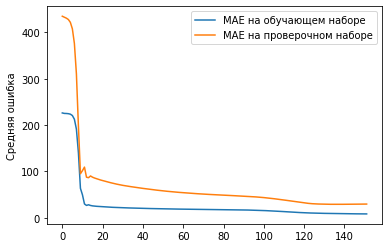

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 110.0713 - mae: 8.1320 - val_loss: 1309.8673 - val_mae: 29.5801
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 109.7588 - mae: 8.0920 - val_loss: 1299.8624 - val_mae: 29.4534
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 109.7939 - mae: 8.1624 - val_loss: 1327.3569 - val_mae: 29.8353
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 111.0649 - mae: 8.1633 - val_loss: 1292.4224 - val_mae: 29.3661
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 115.8336 - mae: 8.5243 - val_loss: 1369.8479 - val_mae: 30.4231
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 130.7361 - mae: 8.9665 - val_loss: 1263.1869 - val_mae: 28.8915
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 177.8783 - mae: 10.5577 - val_loss: 1510.2452 - val_mae: 32.2904
Epoch 8/10
13/13 [=============================

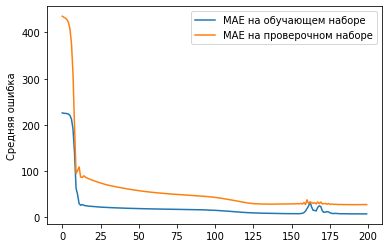

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 99.3070 - mae: 7.6259 - val_loss: 1159.8269 - val_mae: 27.7644
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 98.4959 - mae: 7.6376 - val_loss: 1164.4266 - val_mae: 27.9047
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 98.3712 - mae: 7.6413 - val_loss: 1164.8352 - val_mae: 27.9836
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 98.4133 - mae: 7.5976 - val_loss: 1162.2760 - val_mae: 27.9022
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 97.6222 - mae: 7.5966 - val_loss: 1166.8250 - val_mae: 28.0580
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 97.5747 - mae: 7.5635 - val_loss: 1167.5605 - val_mae: 28.0851
Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 97.4098 - mae: 7.5646 - val_loss: 1167.3114 - val_mae: 28.0690
Epoch 2/10
13/13 [==============================] - 0s

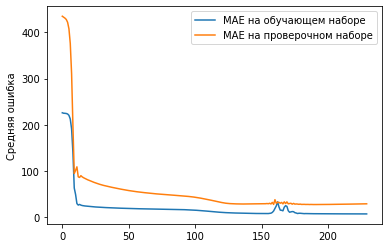

In [28]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])
  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])
  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [29]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 2ms/step


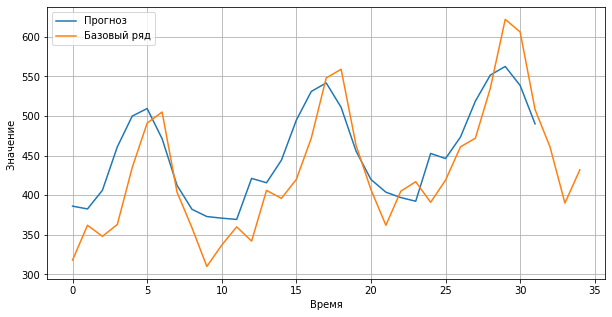

In [30]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')
plt.legend()
plt.show()

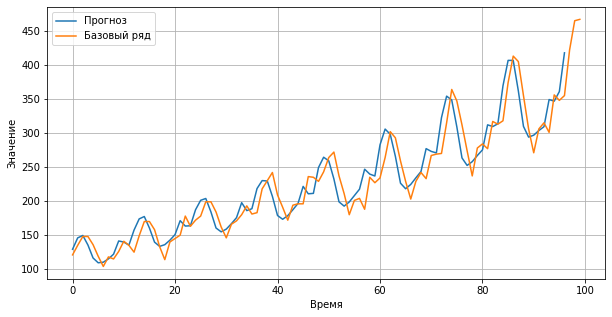

In [31]:
start = 0
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [32]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')
model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 3ms/step - loss: 1233.0688 - mae: 29.2278
train_loss: 84.85697174072266, train_m: 7.072566032409668
test_loss: 1233.06884765625, test_m: 29.227771759033203


In [33]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)
model_2 = Sequential()
model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))
model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [34]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 5s 79ms/step - loss: 56635.5039 - mae: 225.5848 - val_loss: 193099.2344 - val_mae: 432.1109
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 56213.9492 - mae: 224.6866 - val_loss: 191870.6875 - val_mae: 430.7042
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 54962.3516 - mae: 222.1333 - val_loss: 187479.1250 - val_mae: 425.6492
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 50541.6289 - mae: 212.9444 - val_loss: 171140.5156 - val_mae: 406.3455
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 36571.5703 - mae: 180.9397 - val_loss: 118745.1641 - val_mae: 337.2108
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 8376.5869 - mae: 82.5741 - val_loss: 22973.9629 - val_mae: 139.0566
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 5882.3667 - mae: 62.8246 - val_loss: 6899.1328 - val_mae: 67.3650


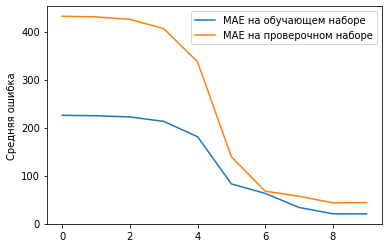

In [35]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [36]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 664.7403 - mae: 20.0167 - val_loss: 3473.6343 - val_mae: 43.8777
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 651.6576 - mae: 19.7305 - val_loss: 3395.9177 - val_mae: 43.5127
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 644.5570 - mae: 19.5860 - val_loss: 3461.2266 - val_mae: 43.6723
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 642.1570 - mae: 19.6200 - val_loss: 3398.1709 - val_mae: 43.4037
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 640.6664 - mae: 19.5978 - val_loss: 3396.0281 - val_mae: 43.3773
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 639.1292 - mae: 19.5732 - val_loss: 3367.7441 - val_mae: 43.2519
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 637.6509 - mae: 19.5478 - val_loss: 3353.7461 - val_mae: 43.1848
Epoch 8/10
13/13 [================

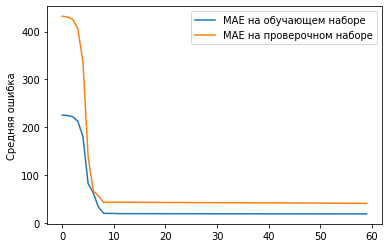

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 583.6990 - mae: 19.0050 - val_loss: 2800.4680 - val_mae: 40.9211
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 582.2144 - mae: 18.9930 - val_loss: 2787.6089 - val_mae: 40.8373
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 580.6852 - mae: 18.9798 - val_loss: 2774.6729 - val_mae: 40.7507
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 579.1082 - mae: 18.9652 - val_loss: 2761.6484 - val_mae: 40.6614
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 577.4787 - mae: 18.9493 - val_loss: 2748.5359 - val_mae: 40.5691
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 575.7935 - mae: 18.9330 - val_loss: 2735.3240 - val_mae: 40.4738
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 574.0478 - mae: 18.9151 - val_loss: 2722.0081 - val_mae: 40.3753
Epoch 8/10
13/13 [=================

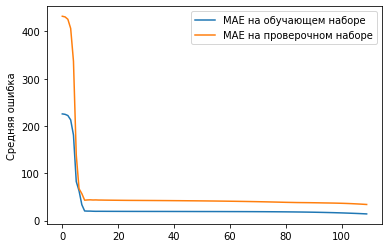

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 301.6762 - mae: 13.7909 - val_loss: 1644.8145 - val_mae: 33.7185
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 288.3508 - mae: 13.4915 - val_loss: 1595.6396 - val_mae: 33.4426
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 275.1709 - mae: 13.1785 - val_loss: 1545.8308 - val_mae: 33.1331
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 262.2775 - mae: 12.8646 - val_loss: 1495.7383 - val_mae: 32.7905
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 249.8141 - mae: 12.5706 - val_loss: 1445.7762 - val_mae: 32.4164
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 237.9201 - mae: 12.2807 - val_loss: 1396.4099 - val_mae: 32.0134
Epoch 7/10
13/13 [==============================] - 0s 11ms/step - loss: 226.7234 - mae: 11.9844 - val_loss: 1348.0889 - val_mae: 31.5849
Epoch 8/10
13/13 [================

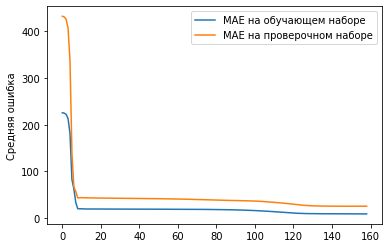

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 139.3046 - mae: 9.0339 - val_loss: 873.7007 - val_mae: 25.6327
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 138.9747 - mae: 9.0263 - val_loss: 875.4577 - val_mae: 25.6834
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 138.6324 - mae: 9.0282 - val_loss: 879.5707 - val_mae: 25.7799
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 138.3683 - mae: 9.0273 - val_loss: 883.3502 - val_mae: 25.8680
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 138.2023 - mae: 9.0134 - val_loss: 883.6454 - val_mae: 25.8859
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 138.0702 - mae: 8.9906 - val_loss: 881.0870 - val_mae: 25.8456
Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 137.8152 - mae: 8.9767 - val_loss: 880.4873 - val_mae: 25.8409
Epoch 2/10
13/13 [==============================]

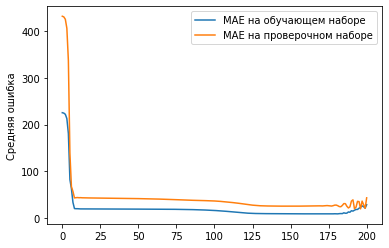

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 250.1746 - mae: 12.4462 - val_loss: 879.4910 - val_mae: 25.6158
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 385.8728 - mae: 17.1043 - val_loss: 699.3527 - val_mae: 21.6259
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 224.3025 - mae: 12.6869 - val_loss: 1220.3419 - val_mae: 30.3218
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 184.6620 - mae: 11.1151 - val_loss: 1152.7651 - val_mae: 29.7111
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 186.0845 - mae: 11.1983 - val_loss: 750.2525 - val_mae: 23.2067
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 140.9090 - mae: 9.2536 - val_loss: 955.2714 - val_mae: 26.4318
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 151.5444 - mae: 9.9056 - val_loss: 1104.1512 - val_mae: 29.0157
Epoch 1/10
13/13 [======================

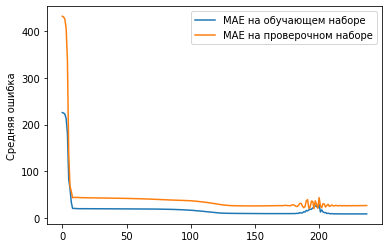

In [37]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])
  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [38]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 2ms/step


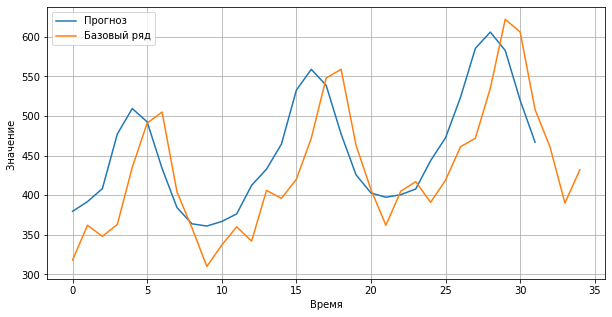

In [39]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')
plt.legend()
plt.show()

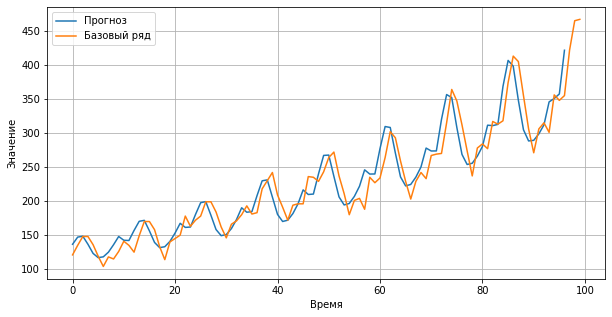

In [40]:
start = 0
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [41]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')
model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 3ms/step - loss: 932.7461 - mae: 26.3420
train_loss: 104.71088409423828, train_m: 7.82891845703125
test_loss: 932.74609375, test_m: 26.342025756835938


In [42]:
batch_size = 8
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [45]:
model_3 = Sequential()
model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=False
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))
model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 3, 32)             3456      
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 14023 (54.78 KB)
Trainable params: 14023

In [46]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 3s 59ms/step - loss: 56897.6328 - mae: 225.8651 - val_loss: 195526.8125 - val_mae: 434.8703
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 56318.1836 - mae: 224.6004 - val_loss: 193623.6250 - val_mae: 432.7282
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 55784.1992 - mae: 223.6406 - val_loss: 191308.9219 - val_mae: 430.1213
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 54461.8789 - mae: 221.0783 - val_loss: 186213.2500 - val_mae: 424.3345
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 50496.3164 - mae: 213.0074 - val_loss: 172177.5625 - val_mae: 407.9296
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 38823.9062 - mae: 186.6158 - val_loss: 133435.7500 - val_mae: 358.4309
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 14185.1865 - mae: 107.8607 - val_loss: 54087.5781 - val_mae: 222.8416

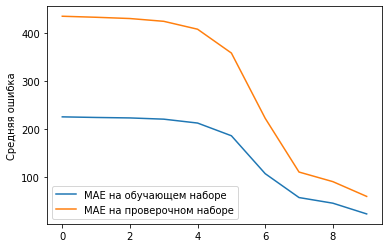

In [47]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [48]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 779.2023 - mae: 22.4062 - val_loss: 5267.3301 - val_mae: 52.3656
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 717.7683 - mae: 21.3020 - val_loss: 5719.8042 - val_mae: 54.7267
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 716.7552 - mae: 21.3445 - val_loss: 5541.8398 - val_mae: 53.7561
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 708.1464 - mae: 21.1373 - val_loss: 5563.8247 - val_mae: 53.9199
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 695.9172 - mae: 20.8656 - val_loss: 5586.1528 - val_mae: 54.1065
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 692.8864 - mae: 20.8314 - val_loss: 5479.7734 - val_mae: 53.4967
Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 688.0890 - mae: 20.7344 - val_loss: 5421.5615 - val_mae: 53.2076
Epoch 2/10
13/13 [=====================

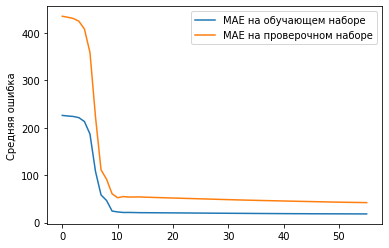

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 551.6075 - mae: 18.2122 - val_loss: 3496.9541 - val_mae: 41.8825
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 549.6946 - mae: 18.1823 - val_loss: 3469.8618 - val_mae: 41.7010
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 547.8271 - mae: 18.1526 - val_loss: 3443.4985 - val_mae: 41.5211
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 546.0013 - mae: 18.1230 - val_loss: 3417.8298 - val_mae: 41.3429
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 544.2142 - mae: 18.0935 - val_loss: 3392.8147 - val_mae: 41.1662
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 542.4615 - mae: 18.0640 - val_loss: 3368.4219 - val_mae: 40.9913
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 540.7396 - mae: 18.0349 - val_loss: 3344.6133 - val_mae: 40.8404
Epoch 8/10
13/13 [=======================

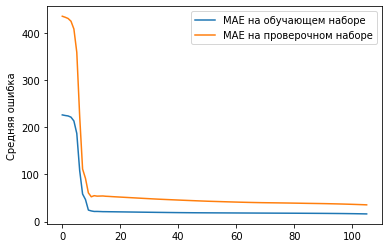

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 419.4666 - mae: 15.9592 - val_loss: 2291.0010 - val_mae: 35.0745
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 412.4803 - mae: 15.8182 - val_loss: 2252.3391 - val_mae: 34.8378
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 405.0784 - mae: 15.6663 - val_loss: 2212.3752 - val_mae: 34.5840
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 397.2527 - mae: 15.5043 - val_loss: 2171.1169 - val_mae: 34.3125
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 388.9983 - mae: 15.3494 - val_loss: 2128.5771 - val_mae: 34.0224
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 380.3163 - mae: 15.1901 - val_loss: 2084.7930 - val_mae: 33.7133
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 371.2129 - mae: 15.0180 - val_loss: 2039.8186 - val_mae: 33.4275
Epoch 8/10
13/13 [=======================

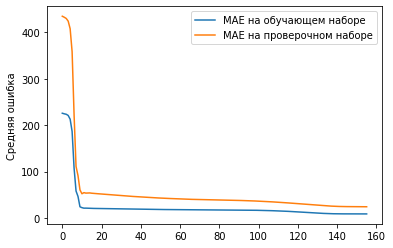

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 127.2205 - mae: 8.8812 - val_loss: 824.1904 - val_mae: 24.3132
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 126.9606 - mae: 8.8715 - val_loss: 822.4756 - val_mae: 24.3033
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 126.7028 - mae: 8.8615 - val_loss: 821.1414 - val_mae: 24.2969
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 126.4511 - mae: 8.8524 - val_loss: 820.0939 - val_mae: 24.2929
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 126.2046 - mae: 8.8437 - val_loss: 819.2333 - val_mae: 24.2896
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 125.9579 - mae: 8.8346 - val_loss: 818.6587 - val_mae: 24.3052
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 125.7157 - mae: 8.8249 - val_loss: 818.2953 - val_mae: 24.3282
Epoch 8/10
13/13 [==============================] - 0s

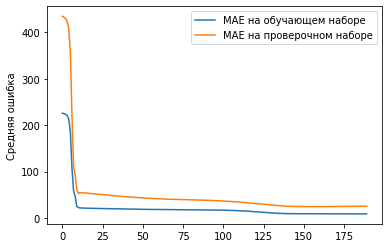

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 119.8265 - mae: 8.5200 - val_loss: 854.6479 - val_mae: 25.2139
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 119.6443 - mae: 8.5104 - val_loss: 857.0352 - val_mae: 25.2529
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 119.4636 - mae: 8.5008 - val_loss: 859.4708 - val_mae: 25.2923
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 119.2844 - mae: 8.4912 - val_loss: 861.9666 - val_mae: 25.3321
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 119.1067 - mae: 8.4815 - val_loss: 864.5111 - val_mae: 25.3723
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 118.9304 - mae: 8.4719 - val_loss: 867.1070 - val_mae: 25.4129
Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 118.7553 - mae: 8.4630 - val_loss: 869.7528 - val_mae: 25.4538
Epoch 2/10
13/13 [==============================] - 0s 

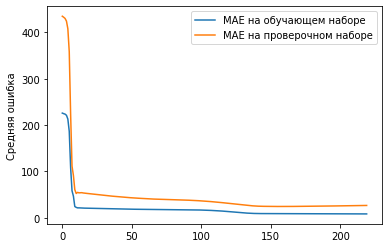

In [49]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])
  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])
  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3, 
            label='MAE на проверочном наборе')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [50]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

5/5 [==============================] - 0s 2ms/step


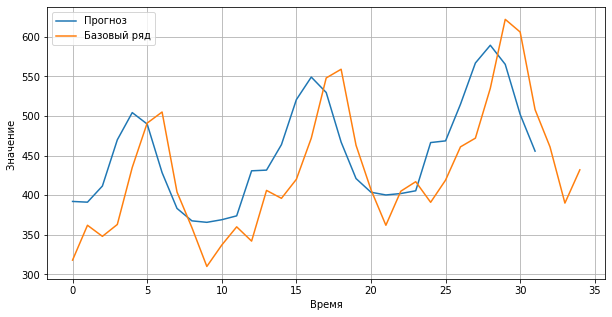

In [51]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')
plt.legend()
plt.show()

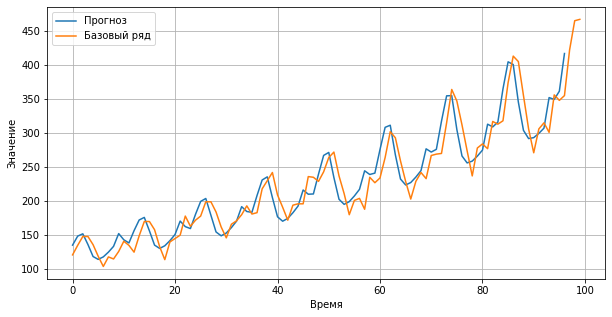

In [52]:
start = 0
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [53]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')
model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 2ms/step - loss: 941.4884 - mae: 26.5265
train_loss: 96.77796936035156, train_m: 7.5886640548706055
test_loss: 941.4884033203125, test_m: 26.52646255493164


In [54]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [55]:
results

,model,train_m,test_m
0,SimpleRNN,7.07,29.23
1,LSTM,7.83,26.34
2,GRU,7.59,26.53


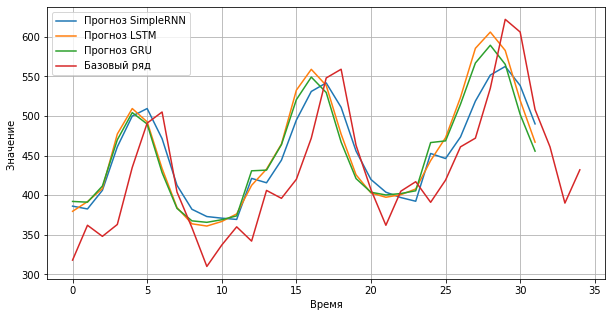

In [56]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')
plt.legend()
plt.show()

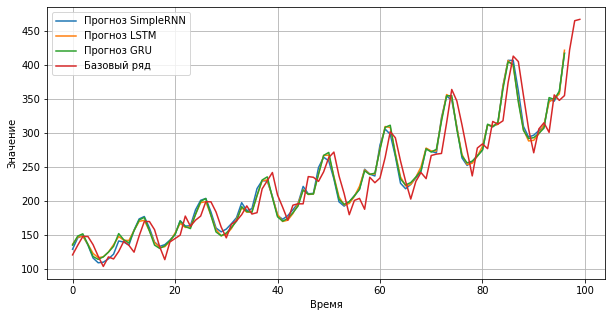

In [57]:
start = 0
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

- Качество повышается с увеличением числа итераций
- Лучше справляется SimpleRNN